<a href="https://colab.research.google.com/github/Czedros/CSE352-Machine-Learning-Assignments/blob/main/CSE352MidtermMakeupAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Name: [Enter Here]

I understand that my submission needs to be my own work: [Initials]

I understand that ChatGPT / Copilot / other AI tools are not allowed:  [Initials]

Total Points: **75**

Complete this notebook and submit it (save/print as pdf). Make sure all output is correct in the pdf before submitting (it sometimes gets cut off).

 The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Overview

In this assignment, you will:
- Implement the rules and structure for Ultimate Tic-Tac-Toe
- Design a Monte Carlo Tree Search (MCTS) agent
- Improve your Monto Carlo Tree Search Agent
- Defeat a Cohort of Challengers with your agent.

#Ultimate Tic-Tac-Toe

Ultimate Tic-Tac-Toe is a strategic extension of the classic Tic-Tac-Toe game. Rather than a single 3×3 grid, Ultimate Tic-Tac-Toe consists of a 3×3 grid where each cell contains another 3×3 Tic-Tac-Toe board. This layered setup creates a more complex game structure requiring players to think multiple moves ahead.

The game was first popularized online in the early 2010s and is designed to emphasize positional play, long-term strategy, and adaptation to an evolving board state. Each player, X or O, takes turns placing their mark in a cell of one of the smaller boards. However, the twist lies in the move constraints: a player’s move determines which of the nine small boards their opponent must play in next. Specifically, if a player places their mark in cell (i, j) of a small board, their opponent must play in the (i, j) small board on their next turn.

The objective is to win the larger game by winning three small boards in a row—horizontally, vertically, or diagonally—similar to classic Tic-Tac-Toe. A small board is won when a player has three marks in a row within it. If a player is sent to a board that is already won or drawn, they may play in any open board of their choosing.

Ultimate Tic-Tac-Toe presents a more intricate challenge than its predecessor and is a rich environment for studying game trees, simulation-based planning, and reinforcement learning. For more information about the game and strategic insights, refer to its [Wikipedia page](https://en.wikipedia.org/wiki/Ultimate_tic-tac-toe).


[Quick Video Demonstration on how the Game works](https://www.youtube.com/shorts/_Na3a1ZrX7c) (Credit: VSauce)

[More In-Depth Guide](https://www.youtube.com/watch?v=37PC0bGMiTI) (Credit: MindYourDecisions - Presh Talwalkar)

#Visualizer Helper

There are 2 ways to go about creating a board for Ultimate Tic Tac Toe, a 9x9 grid or a 3x3 of 3x3 grids. These will result in different ways to visualize the board.


The following is a visuzlizing tool and 2 adapters that can be used depending on your implementation of the game.

#Implementation 1: 9x9 Boards

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def draw_ultimate_board(board, highlight=None):
    """
    Visualizes a 9x9 Ultimate Tic-Tac-Toe board with optional highlight.
    Highlights the relative small board with red short lines.
    """
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)

    # Draw normal grid
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', lw=lw, zorder=0)
        ax.axvline(i, color='black', lw=lw, zorder=0)

    # Draw Xs and Os
    for row in range(9):
        for col in range(9):
            val = board[row, col]
            if val == 1:
                ax.text(col+0.5, 8.5 - row, 'X', ha='center', va='center', fontsize=16)
            elif val == 2:
                ax.text(col+0.5, 8.5 - row, 'O', ha='center', va='center', fontsize=16)

    # Draw highlight precisely
    if highlight:
        hrow, hcol = highlight

        # Bottom-left of highlighted mini-board
        x0 = hcol * 3
        y0 = 6 - hrow * 3

        # Draw 4 red sides manually
        ax.plot([x0, x0+3], [y0, y0], color='red', lw=4)  # Bottom edge
        ax.plot([x0, x0+3], [y0+3, y0+3], color='red', lw=4)  # Top edge
        ax.plot([x0, x0], [y0, y0+3], color='red', lw=4)  # Left edge
        ax.plot([x0+3, x0+3], [y0, y0+3], color='red', lw=4)  # Right edge

    plt.show()



##An example of the visualizer code and how its used

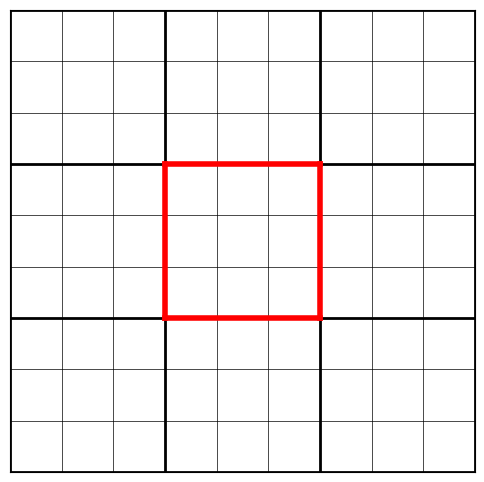

In [11]:
board = np.zeros((9,9), dtype=int)
draw_ultimate_board(board, highlight=(1,1))  # center


#Adapter 1: Using 3x3 of 3x3 arrays

In [12]:
def nested_list_to_board(nested_game, highlight=None):
    """
    Converts a 3x3 list of 3x3 arrays to a 9x9 board and draws it.
    """
    board_array = np.zeros((9, 9), dtype=int)
    for br in range(3):
        for bc in range(3):
            sb = nested_game[br][bc]
            if isinstance(sb, np.ndarray):
                board_array[br*3:(br+1)*3, bc*3:(bc+1)*3] = sb
            else:
                board_array[br*3:(br+1)*3, bc*3:(bc+1)*3] = np.array(sb)

    draw_ultimate_board(board_array, highlight=highlight)


##Example Usage

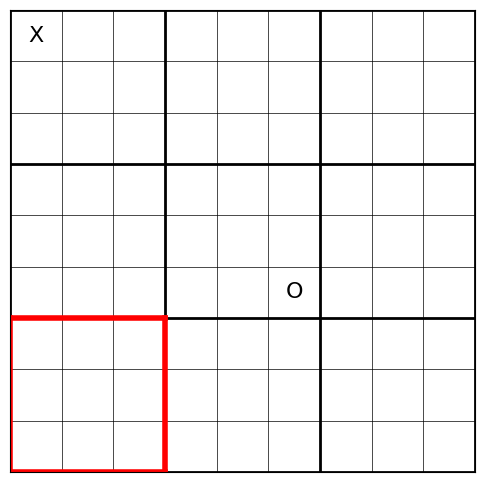

In [13]:
nested_game = [
    [np.zeros((3,3), dtype=int) for _ in range(3)] for _ in range(3)
]
nested_game[0][0][0,0] = 1
nested_game[1][1][2,2] = 2

nested_list_to_board(nested_game, highlight=(2, 0))

#Part 1: Ultimate Tic-Tac-Toe [X Points]
In the first part, you will implement the mechanics of Ultimate Tic-Tac-Toe, defining how the game progresses and determining legal moves and win conditions.

There are an infinite number of ways to do this, and the guidelines will be pretty Lax

Here are two reccomended Methods and the Specifications

##Method 1: 3x3 Implementation

- Create a Small Board Class that contains a basic Tic-Tac-Toe Game
- Create a Big Board Class that contains a 3x3 grid of Small boards
- Implement logic for Tic tac toe..

##Method 2: Loose 9x9 Implementation
- Make a 9x9 grid
- Whenever a Move is made, Check for legality of the move and make it
- Check for wins via checking every 3x3 in code.

##Requirements

Regardless of the methods, several things are mandatory.

- get_legal_moves(self) : Gives a list of legal plays (This is important for the bots!)

- use big_r, big_c, small_r, small_c as the format of the moves (This is important for the bots!)


(Alternatively, give this to students as is, and have them complete just the bots,those are alot of work already, and this was pretty simple)

In [19]:
import numpy as np

class SmallBoard:
    def __init__(self):
        self.grid = np.zeros((3, 3), dtype=int)  # 0 = empty, 1 = X, 2 = O
        self.winner = 0  # 0 = no one, 1 = X, 2 = O, -1 = tie
        self.active = True

    def play_move(self, row, col, player):
        if self.grid[row, col] != 0 or not self.active:
            return False
        self.grid[row, col] = player
        self.check_winner()
        return True

    def check_winner(self):
        for i in range(3):
            if np.all(self.grid[i, :] == self.grid[i, 0]) and self.grid[i, 0] != 0:
                self._declare_winner(self.grid[i, 0])
                return
            if np.all(self.grid[:, i] == self.grid[0, i]) and self.grid[0, i] != 0:
                self._declare_winner(self.grid[0, i])
                return
        if np.all(np.diag(self.grid) == self.grid[0, 0]) and self.grid[0, 0] != 0:
            self._declare_winner(self.grid[0, 0])
            return
        if np.all(np.diag(np.fliplr(self.grid)) == self.grid[0, 2]) and self.grid[0, 2] != 0:
            self._declare_winner(self.grid[0, 2])
            return
        if np.all(self.grid != 0):
            self._declare_winner(-1)

    def _declare_winner(self, winner):
        self.winner = winner
        self.active = False


In [20]:

import numpy as np
import random

class UltimateBoard:
    def __init__(self):
        self.boards = [[SmallBoard() for _ in range(3)] for _ in range(3)]
        self.current_player = 1  # 1 = X, 2 = O
        self.next_board = None  # (row, col) of next board; None means any active board
        self.global_winner = 0

    def play_move(self, big_r, big_c, small_r, small_c):
        board = self.boards[big_r][big_c]
        if self.next_board and (big_r, big_c) != self.next_board:
            print("You must play in board", self.next_board)
            return False
        if not board.play_move(small_r, small_c, self.current_player):
            print("Invalid move.")
            return False

        # Update next board
        next_r, next_c = small_r, small_c
        if self.boards[next_r][next_c].active:
            self.next_board = (next_r, next_c)
        else:
            self.next_board = None  # Any active board

        # Check for global win
        self.check_global_winner()

        # Swap player
        self.current_player = 3 - self.current_player
        return True

    def check_global_winner(self):
        grid = np.array([[b.winner if b.winner > 0 else 0 for b in row] for row in self.boards])
        for i in range(3):
            if np.all(grid[i, :] == grid[i, 0]) and grid[i, 0] != 0:
                self.global_winner = grid[i, 0]
                return
            if np.all(grid[:, i] == grid[0, i]) and grid[0, i] != 0:
                self.global_winner = grid[0, i]
                return
        if np.all(np.diag(grid) == grid[0, 0]) and grid[0, 0] != 0:
            self.global_winner = grid[0, 0]
            return
        if np.all(np.diag(np.fliplr(grid)) == grid[0, 2]) and grid[0, 2] != 0:
            self.global_winner = grid[0, 2]
            return

    def get_legal_moves(self):
        moves = []
        for big_r in range(3):
            for big_c in range(3):
                board = self.boards[big_r][big_c]
                if self.next_board and (big_r, big_c) != self.next_board:
                    continue
                if board.active:
                    for i in range(3):
                        for j in range(3):
                            if board.grid[i, j] == 0:
                                moves.append((big_r, big_c, i, j))
        return moves

    def display(self):
        def cell_symbol(val):
            return '.' if val == 0 else ('X' if val == 1 else 'O')
        for big_r in range(3):
            for r in range(3):
                line = ''
                for big_c in range(3):
                    board = self.boards[big_r][big_c]
                    line += ' '.join(cell_symbol(board.grid[r, c]) for c in range(3)) + ' | '
                print(line)
            print('-' * 20)


In [21]:
def ultimate_board_to_board(game, highlight=None):
    board_array = np.zeros((9, 9), dtype=int)
    for br in range(3):
        for bc in range(3):
            sb = game.boards[br][bc].grid
            board_array[br*3:(br+1)*3, bc*3:(bc+1)*3] = sb

    # If highlight not given, automatically use game's next_board if available
    if highlight is None and hasattr(game, 'next_board'):
        highlight = game.next_board

    draw_ultimate_board(board_array, highlight=highlight)



In [22]:
def play_game(agent_X=None, agent_O=None):
    game = UltimateBoard()

    while not game.global_winner and game.get_legal_moves():
        print("\nCurrent Turn: Player {}".format("X" if game.current_player == 1 else "O"))
        ultimate_board_to_board(game)

        if game.next_board:
            print("You must play in small board:", game.next_board)
        else:
            print("You may play in any active board.")

        # Determine agent for this turn
        agent = agent_X if game.current_player == 1 else agent_O

        if agent is None:
            # Human move
            move = input("Enter your move (big_r big_c small_r small_c): ").split()
            try:
                move = tuple(map(int, move))
                if len(move) != 4 or not game.play_move(*move):
                    print("Try again.")
            except:
                print("Invalid input.")
        else:
            # Bot move
            move = agent(game)
            print(f"Bot plays: {move}")
            game.play_move(*move)

    print("\nFinal Result:")
    ultimate_board_to_board(game)
    if game.global_winner:
        print("Winner: Player", "X" if game.global_winner == 1 else "O")
    else:
        print("Game ended in a draw.")

#Test 1: Random Bot

Implement a bot that makes Random Moves, and have it play against itself! Use this to test out whether your game is working correctly, and see how the game plays.



Final Result:


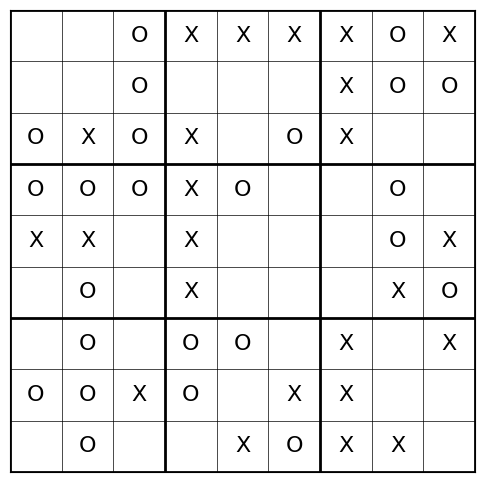

Winner: Player O


In [46]:
def random_bot(board: UltimateBoard):
    return random.choice(board.get_legal_moves())

def play_game(agent_X=None, agent_O=None):
    game = UltimateBoard()

    while not game.global_winner and game.get_legal_moves():
        agent = agent_X if game.current_player == 1 else agent_O

        if agent is None:
            # Human move
            move = input("Enter your move (big_r big_c small_r small_c): ").split()
            try:
                move = tuple(map(int, move))
                if len(move) != 4 or not game.play_move(*move):
                    print("Try again.")
            except:
                print("Invalid input.")
        else:
            # Bot move
            move = agent(game)
            game.play_move(*move)

    print("\nFinal Result:")
    ultimate_board_to_board(game)
    if game.global_winner:
        print("Winner: Player", "X" if game.global_winner == 1 else "O")
    else:
        print("Game ended in a draw.")

play_game(agent_X=random_bot, agent_O=random_bot)

#**Part 2: Monte Carlo Tree Search [X Points]**

The second part of this assignment is creating an agent that uses Monte-Carlo Tree Search (MCTS) that can take a game to play it.

##**A Quick Introduction to MCTS**
Monte Carlo Tree Search (MCTS) is a popular algorithm for making decisions in large, complex environments, especially games like Go, Chess, and Ultimate Tic-Tac-Toe.

At its core, MCTS builds a search tree dynamically by simulating many possible future plays of the game. Instead of analyzing all moves exhaustively (which would be impossible in very large games), it randomly explores promising options and gradually focuses on the best strategies.

**MCTS operates through four key phases:**

- Selection
  - Starting at the root, recursively select child nodes that appear most promising, balancing exploration (trying new moves) and exploitation (choosing moves known to be good).
- Expansion
  - When reaching a node with unexplored moves, add one or more child nodes representing these new possibilities.
- Simulation (Rollout)
  - From the newly expanded node, simulate a random (or semi-random) playout to the end of the game to estimate how good that move might be.
- Backpropagation
  - Propagate the result of the simulation back up the tree, updating statistics (like win counts) for all nodes visited during selection.

By repeating these four phases thousands of times, MCTS gradually builds a "map" of the most promising moves without ever having to fully solve the game.

##Additional Resources
- [Wikipedia](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search)
- [Builtin](https://builtin.com/machine-learning/monte-carlo-tree-search)
- [Video](https://www.youtube.com/watch?v=UXW2yZndl7U) by John Levine

#**Part 2: Implementation**

For this, we will be splitting it into 4 small componnets:

- Component 1: MCTS Nodes

- Component 2: State Copy Function

- Component 3: MCTS Main Loop


## **Component 1: MCTS Nodes**

The first of these components is the Node itself.

The Node class keeps track of

In [34]:
import random
import math
class MCTSNode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = game_state
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.total_reward = 0.0
        self.untried_moves = game_state.get_legal_moves() if game_state.global_winner == 0 else []

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def select_child(self, exploration_weight=1.414):
        best_score = -float('inf')
        best_children = []

        for child in self.children:
            if child.visits == 0:
                score = float('inf')
            else:
                # UCB1 formula
                exploitation = child.total_reward / child.visits
                exploration = exploration_weight * math.sqrt(math.log(self.visits) / child.visits)
                score = exploitation + exploration
            if score > best_score:
                best_score = score
                best_children = [child]
            elif score == best_score:
                best_children.append(child)
        return random.choice(best_children)

    def __repr__(self):
        return f"Node(move={self.move}, visits={self.visits}, reward={self.total_reward})"


## **Component 2: MCTS Nodes**

The second important component here is

In [49]:
def copy_ultimate_board(original):
    new_board = UltimateBoard()
    new_board.current_player = original.current_player
    new_board.next_board = original.next_board
    new_board.global_winner = original.global_winner

    for i in range(3):
        for j in range(3):
            orig_sb = original.boards[i][j]
            new_sb = SmallBoard()
            new_sb.grid = orig_sb.grid.copy()
            new_sb.winner = orig_sb.winner
            new_sb.active = orig_sb.active
            new_board.boards[i][j] = new_sb
    return new_board


## **Component 3: MCTS Main Loop**

The Final component is the Main Loop/function itself. This is where we tie together the whole

In [39]:
def mcts(ultimate_board, iterations=500):
    root = MCTSNode(copy_ultimate_board(ultimate_board))

    for _ in range(iterations):
        node = root
        path = [node]

        # Selection
        while not node.game_state.global_winner and node.is_fully_expanded() and node.children:
          node = node.select_child()
          path.append(node)

        # If game ended in this node, get result
        if node.game_state.global_winner != 0:
            reward = 0.0
            if node.game_state.global_winner == root.game_state.current_player:
                reward = 1.0
            elif node.game_state.global_winner == -1:
                reward = 0.5
        else:
            # Expansion
            if node.untried_moves:
                move = node.untried_moves.pop()
                new_game = copy_ultimate_board(node.game_state)
                new_game.play_move(*move)
                child = MCTSNode(new_game, parent=node, move=move)
                node.children.append(child)
                path.append(child)
                node = child

            # Simulation
            sim_game = copy_ultimate_board(node.game_state)
            while sim_game.global_winner == 0 and sim_game.get_legal_moves():
                move = random.choice(sim_game.get_legal_moves())
                sim_game.play_move(*move)

            # Determine reward from root player's perspective
            if sim_game.global_winner == root.game_state.current_player:
                reward = 1.0
            elif sim_game.global_winner == -1:
                reward = 0.5
            else:
                reward = 0.0

        # Backpropagation
        for n in path:
            n.visits += 1
            n.total_reward += reward

    # Choose the child with the highest visit count
    if not root.children:
        return random.choice(ultimate_board.get_legal_moves())

    best_move = max(root.children, key=lambda c: c.visits).move
    return best_move

def mcts_bot(game):
    return mcts_bot(game, iterations=500)  # Adjust iterations as needed

##**Testing Your MCTS Bot** (X Points)

Have your MCTS Bot play against both the random agent for 5 games, and have it play against itself for 5 games.

Modify its iteration count for each of the games, and then do the following for each game:

- Print out a table containing the Iteration count and its corresponding winrate

- Perform small write up on the results, and if they matched your predictions


Testing MCTS vs Random Agent...


Final Result:


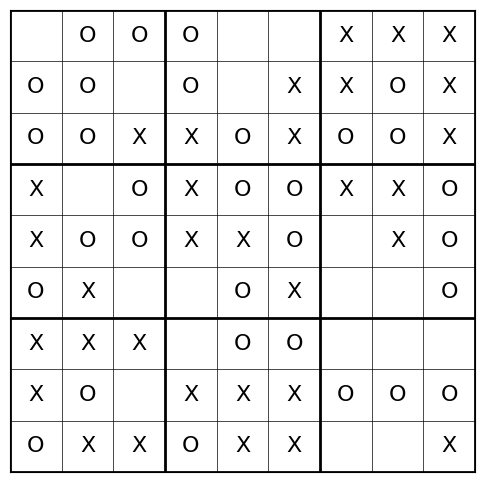

Winner: Player X

Final Result:


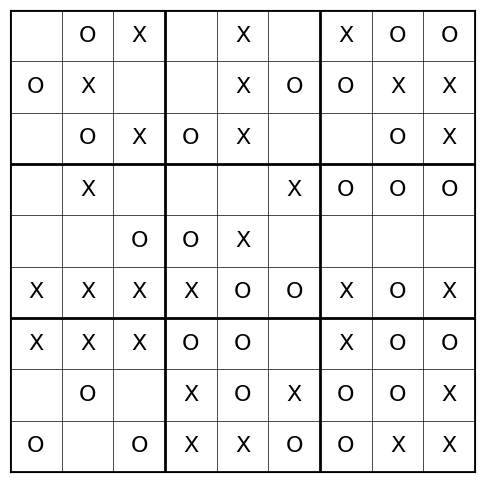

Winner: Player X

Final Result:


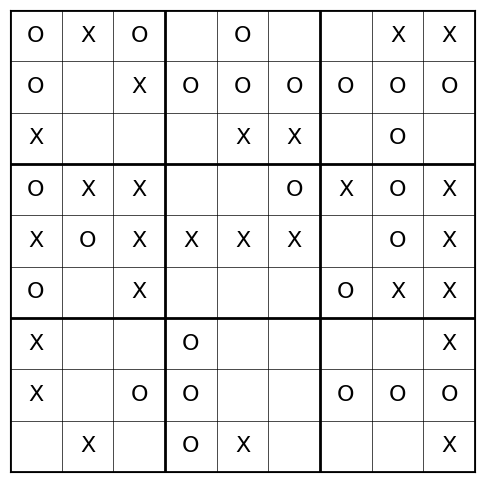

Winner: Player X

Final Result:


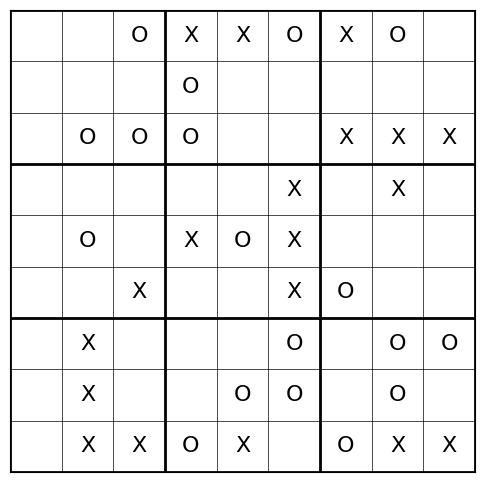

Winner: Player X

Final Result:


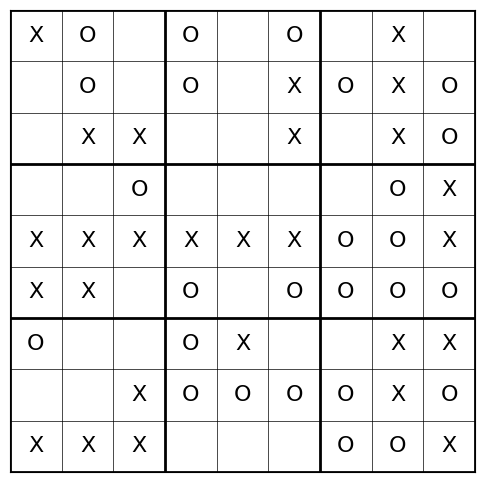

Winner: Player X
Iterations: 50 | Winrate vs Random: 0.00

Final Result:


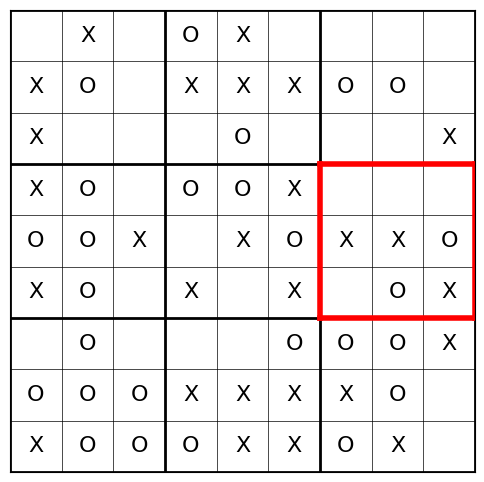

Winner: Player X

Final Result:


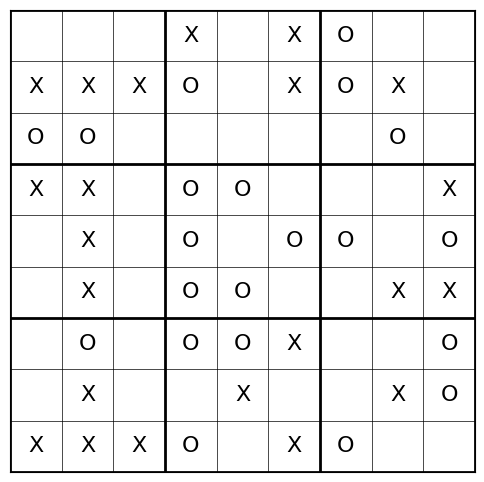

Winner: Player X

Final Result:


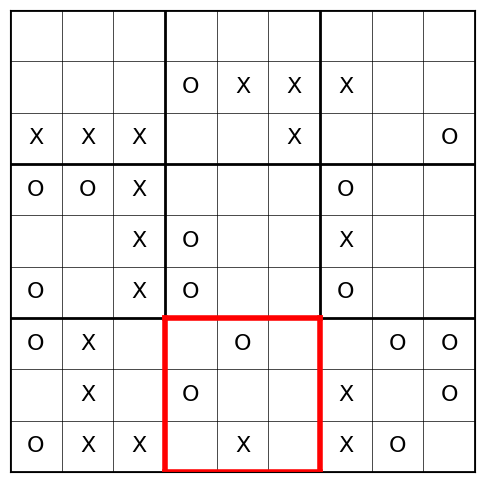

Winner: Player X

Final Result:


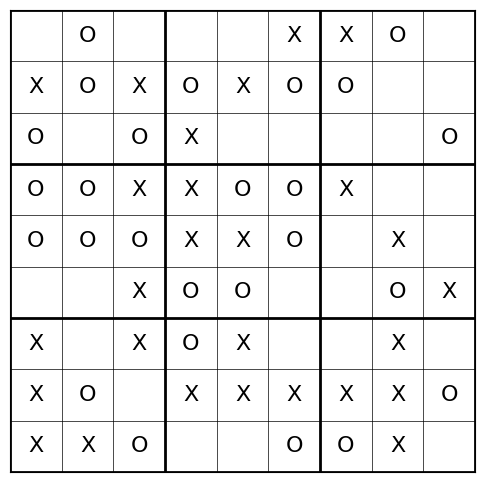

Winner: Player X

Final Result:


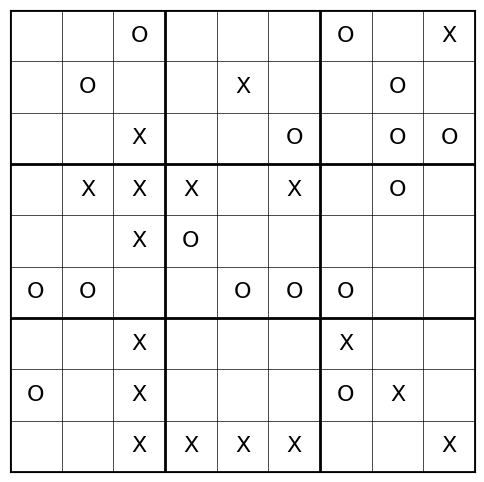

Winner: Player X
Iterations: 100 | Winrate vs Random: 0.00

Final Result:


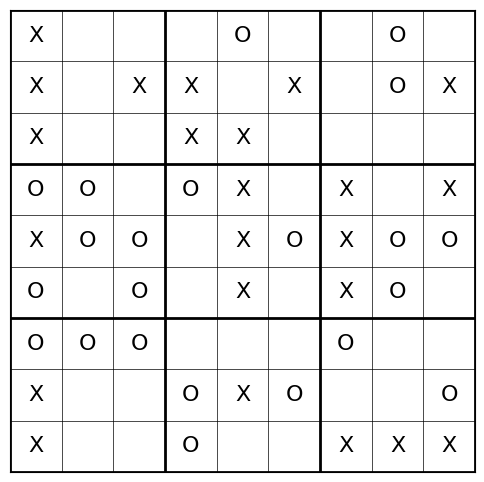

Winner: Player X

Final Result:


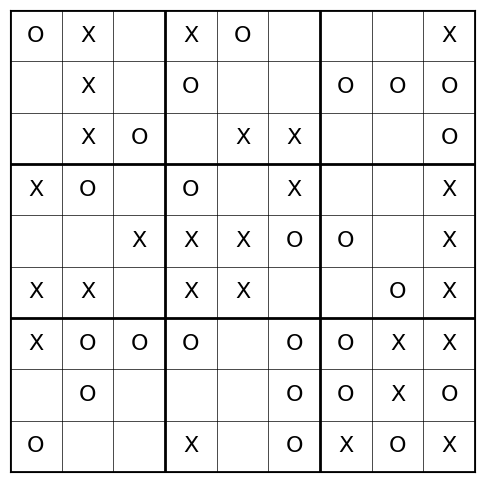

Winner: Player X

Final Result:


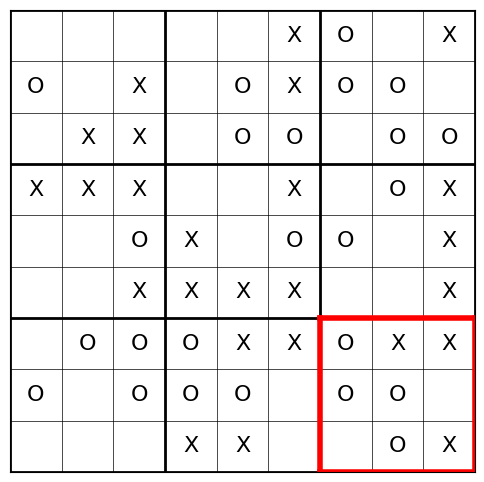

Winner: Player X

Final Result:


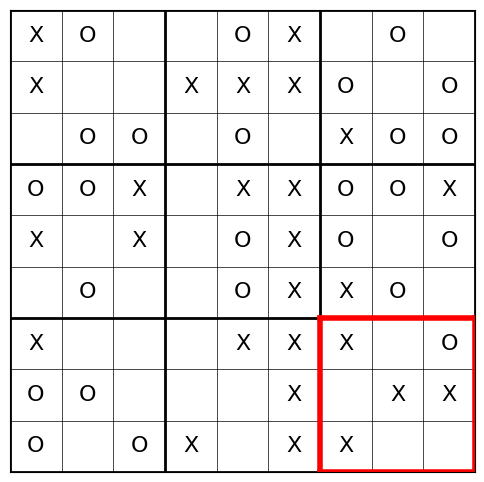

Winner: Player X

Final Result:


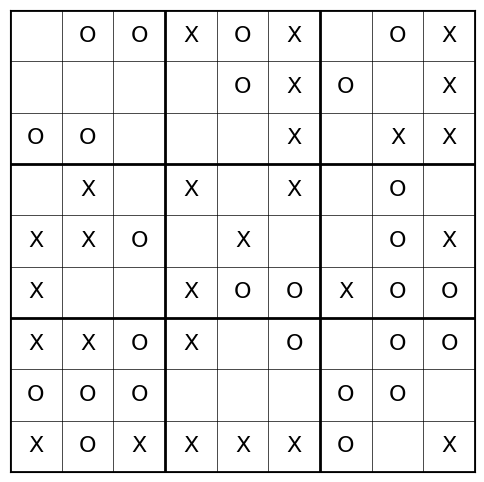

Winner: Player X
Iterations: 150 | Winrate vs Random: 0.00

Final Result:


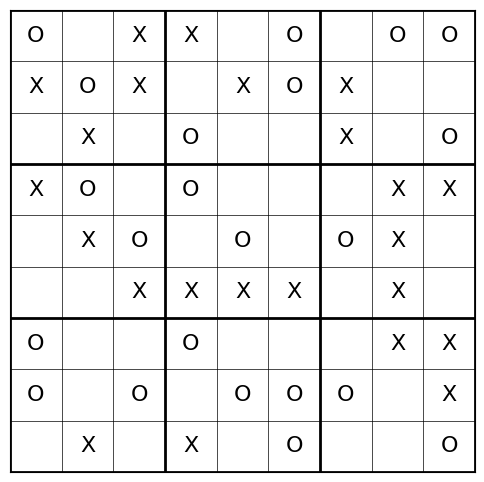

Winner: Player X

Final Result:


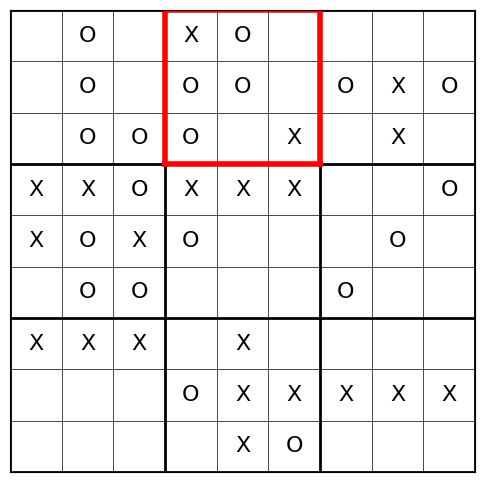

Winner: Player X

Final Result:


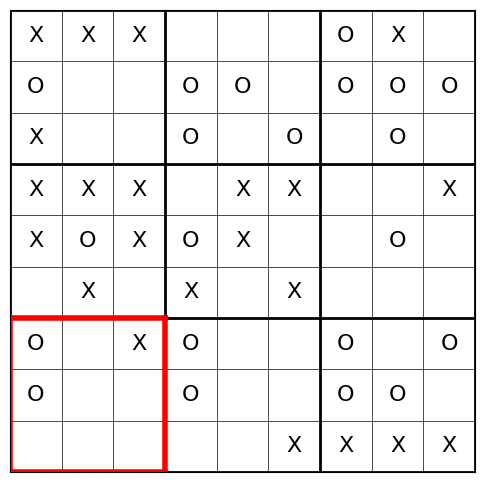

Winner: Player X

Final Result:


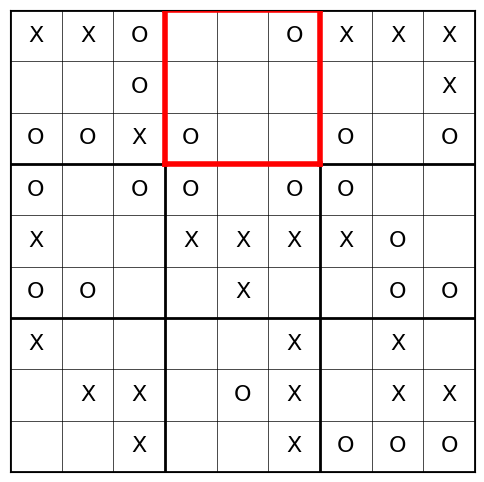

Winner: Player X

Final Result:


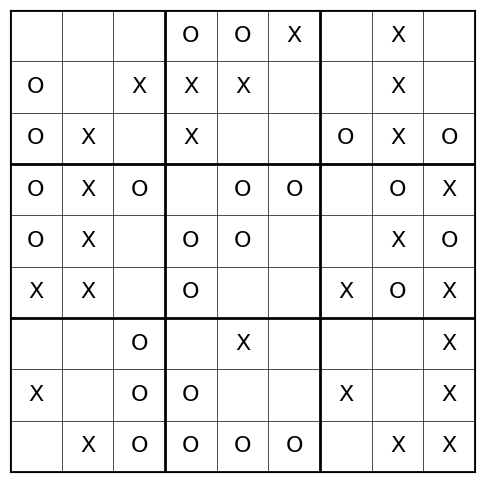

Winner: Player X
Iterations: 200 | Winrate vs Random: 0.00

Final Result:


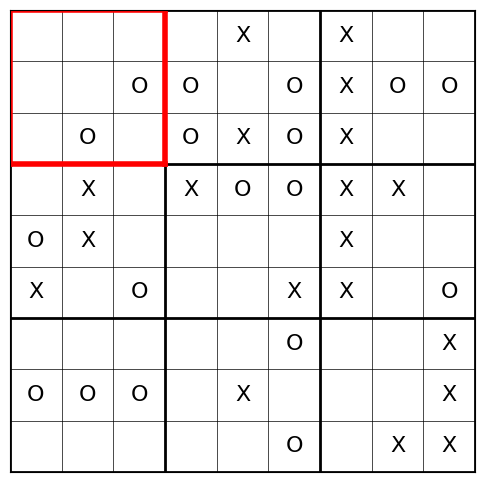

Winner: Player X

Final Result:


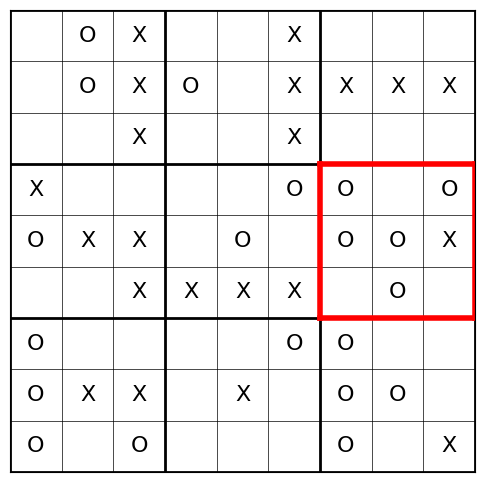

Winner: Player X

Final Result:


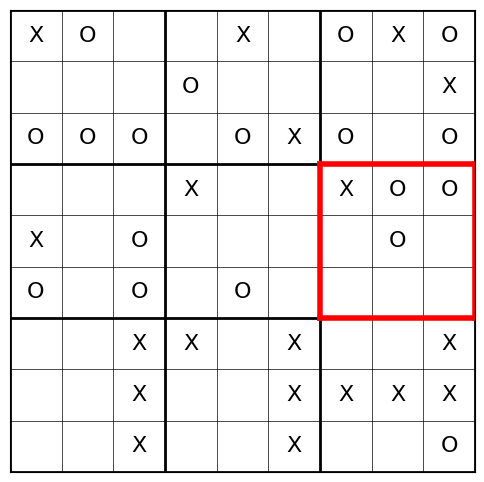

Winner: Player X

Final Result:


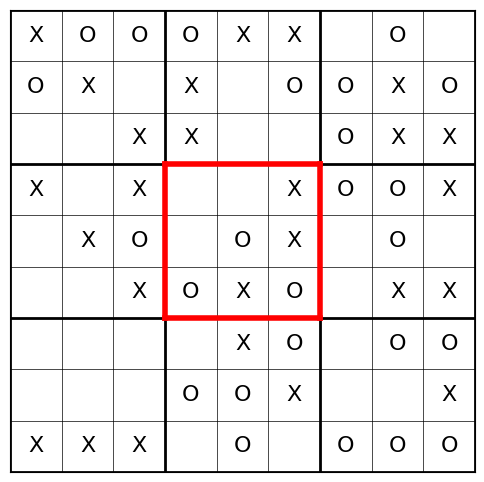

Winner: Player X

Final Result:


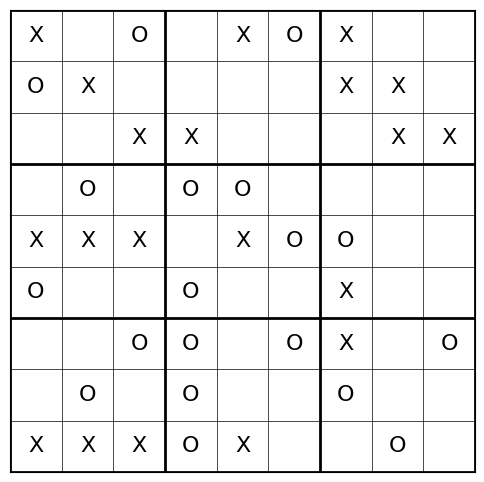

Winner: Player X
Iterations: 500 | Winrate vs Random: 0.00

Testing MCTS vs MCTS...


Final Result:


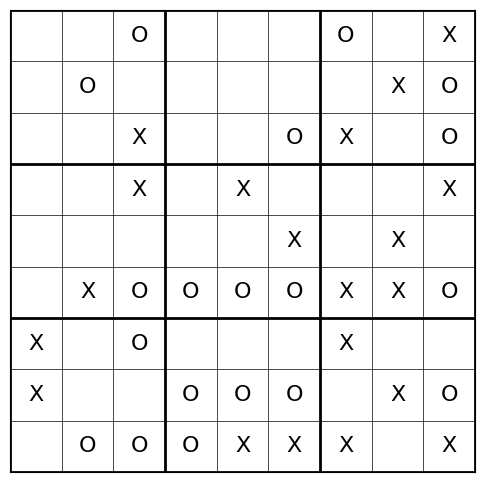

Winner: Player X

Final Result:


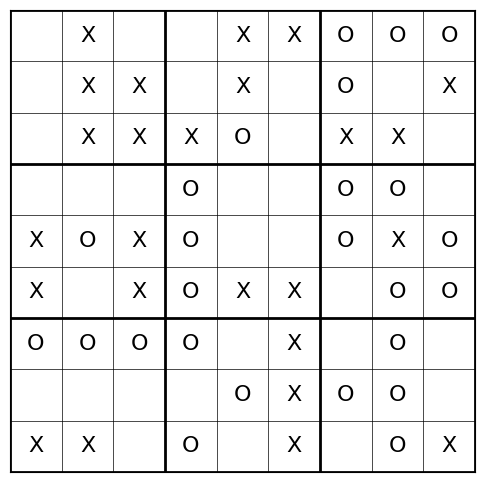

Winner: Player O

Final Result:


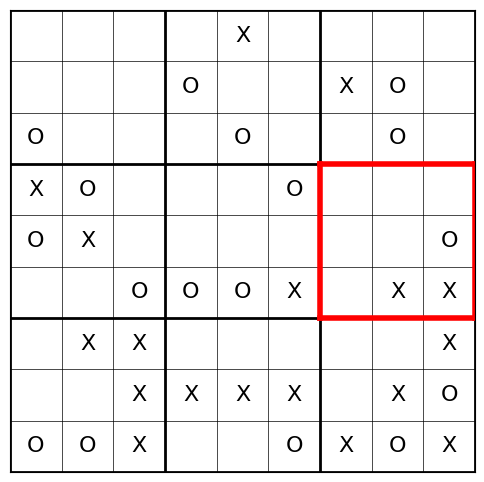

Winner: Player X

Final Result:


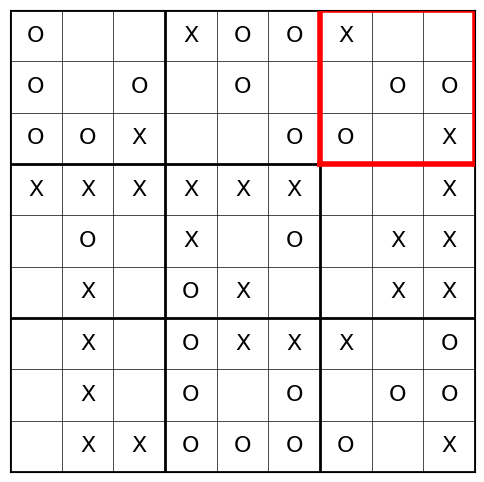

Winner: Player X

Final Result:


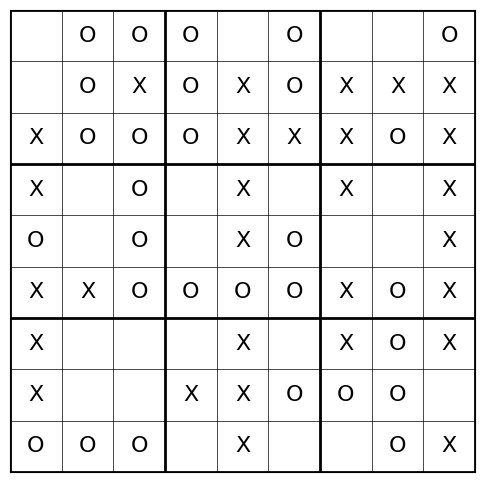

Winner: Player O
Iterations: 50 | Winrate vs Self (X winrate): 0.00

Final Result:


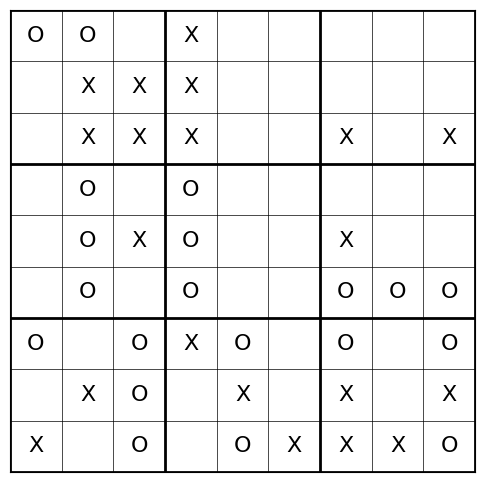

Winner: Player O

Final Result:


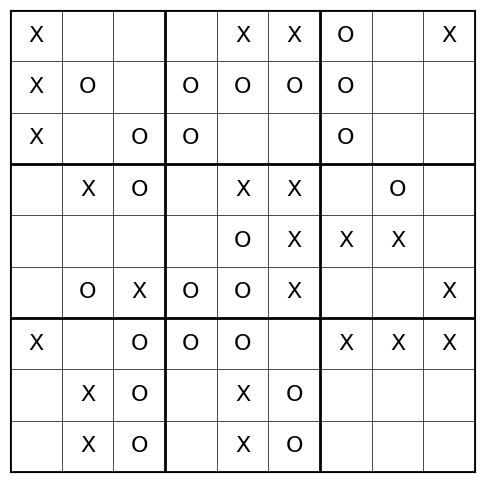

Winner: Player X

Final Result:


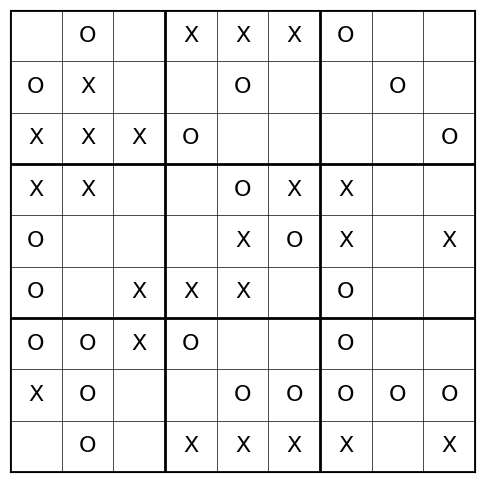

Winner: Player X

Final Result:


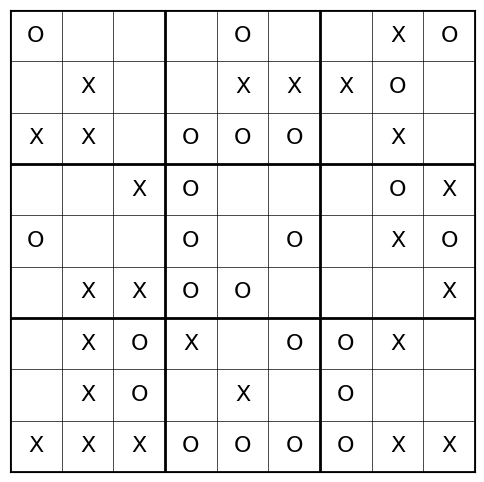

Winner: Player O

Final Result:


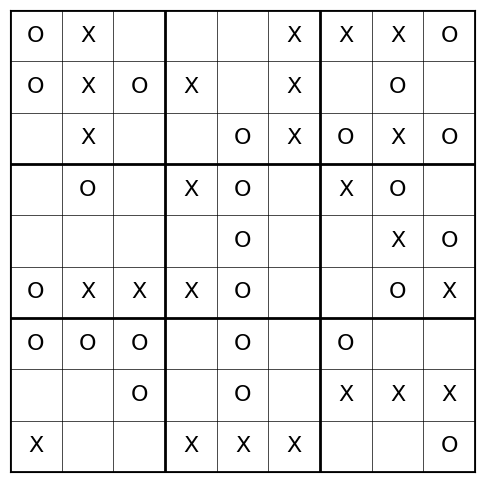

Winner: Player O
Iterations: 100 | Winrate vs Self (X winrate): 0.00

Final Result:


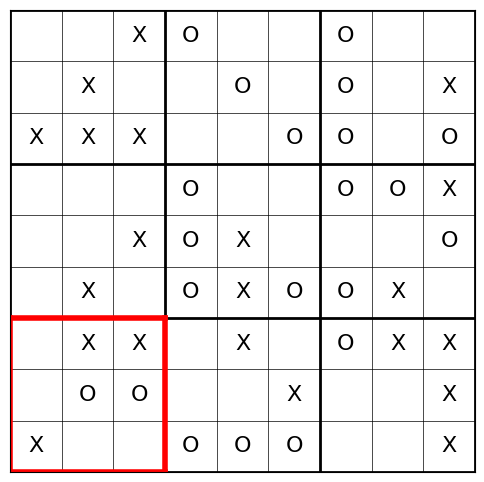

Winner: Player O

Final Result:


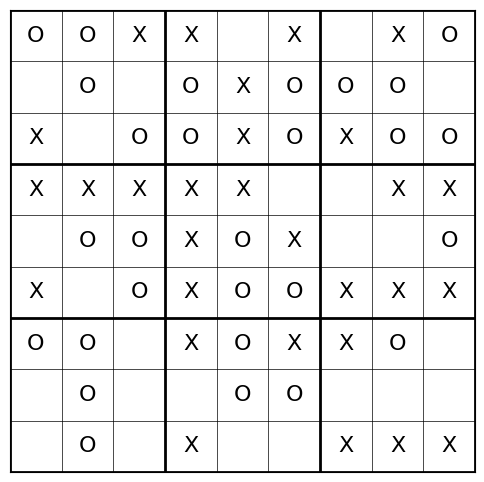

Winner: Player X

Final Result:


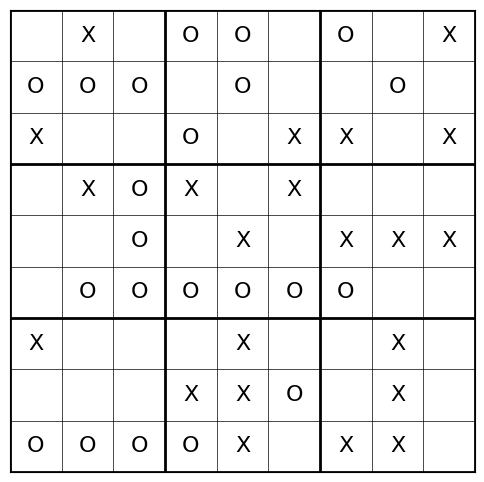

Winner: Player O

Final Result:


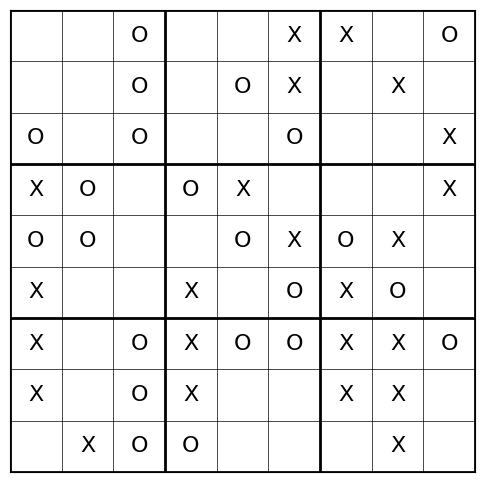

Winner: Player X

Final Result:


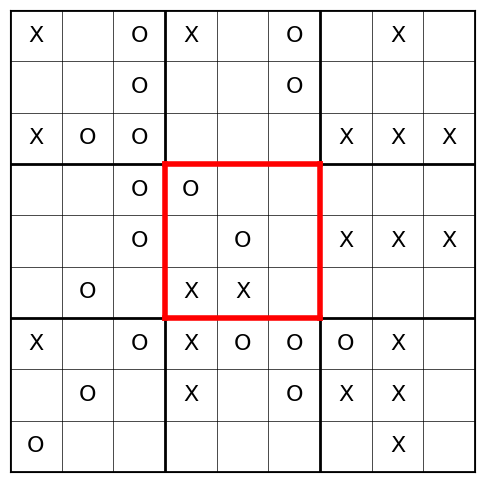

Winner: Player X
Iterations: 150 | Winrate vs Self (X winrate): 0.00

Final Result:


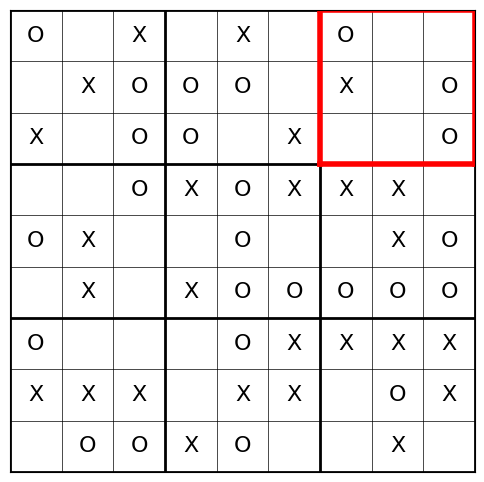

Winner: Player X

Final Result:


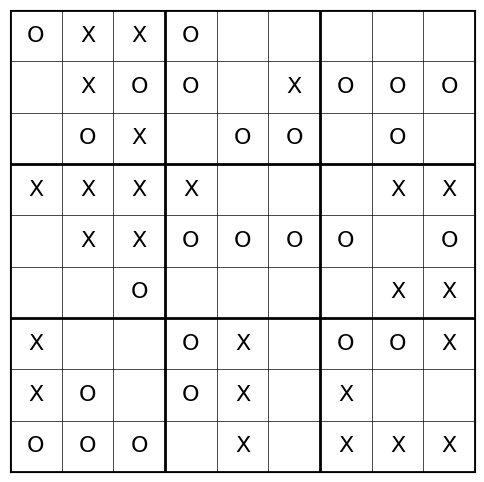

Winner: Player O

Final Result:


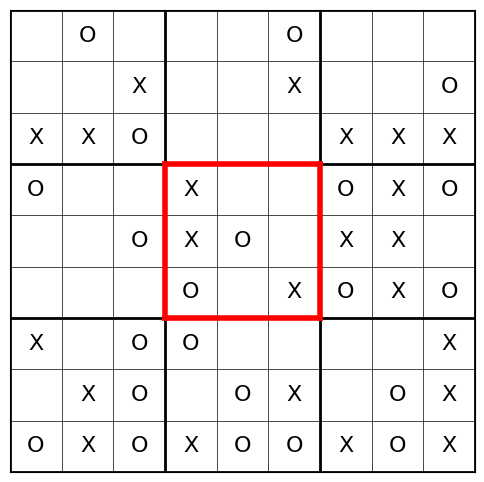

Winner: Player X

Final Result:


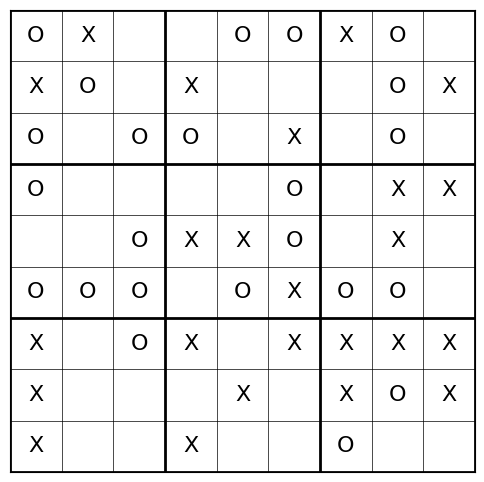

Winner: Player X

Final Result:


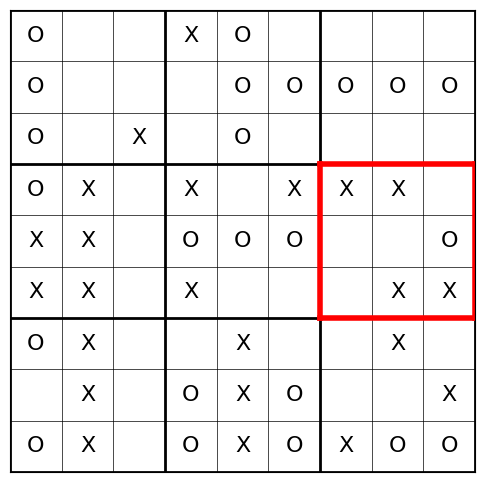

Winner: Player O
Iterations: 200 | Winrate vs Self (X winrate): 0.00

Final Result:


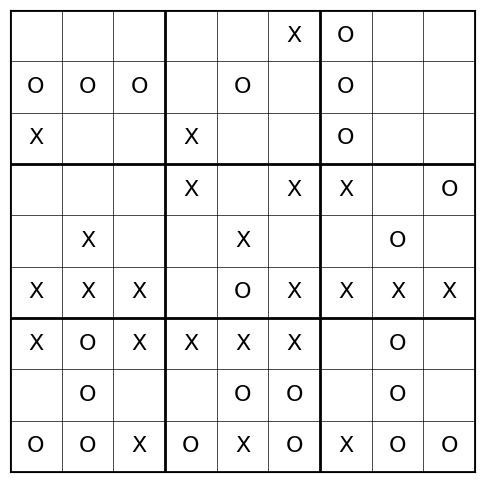

Winner: Player X

Final Result:


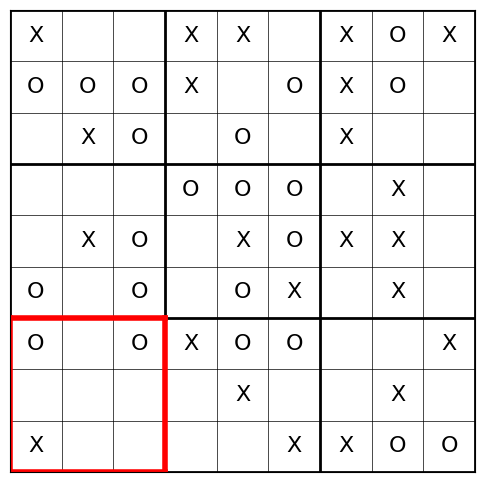

Winner: Player X

Final Result:


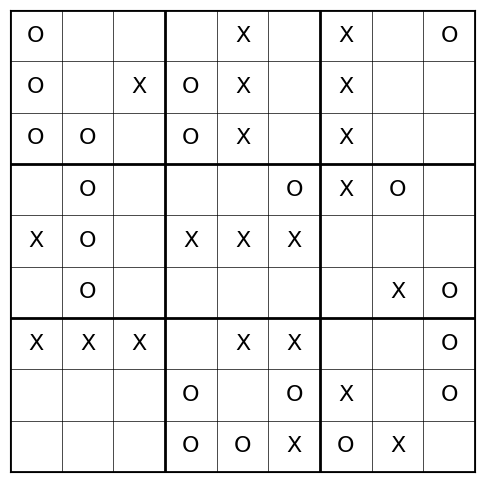

Winner: Player X

Final Result:


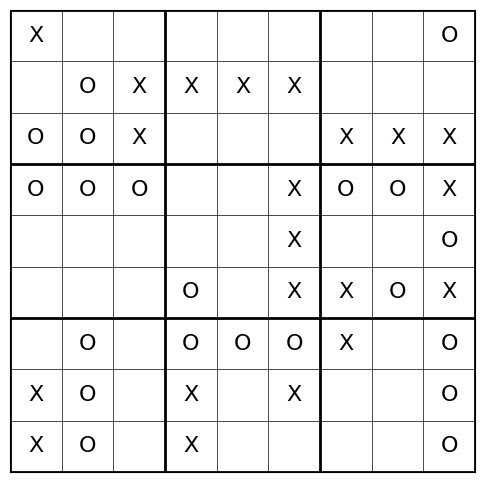

Winner: Player O

Final Result:


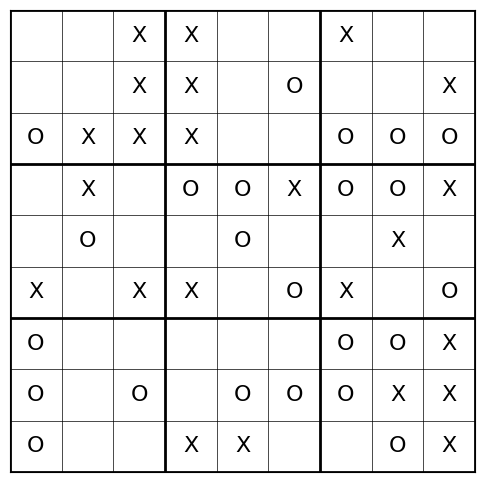

Winner: Player O
Iterations: 500 | Winrate vs Self (X winrate): 0.00

Summary Table: MCTS vs Random
   Iterations  Winrate_vs_Random
0          50                0.0
1         100                0.0
2         150                0.0
3         200                0.0
4         500                0.0

Summary Table: MCTS vs MCTS
   Iterations  Winrate_vs_SelfPlay
0          50                  0.0
1         100                  0.0
2         150                  0.0
3         200                  0.0
4         500                  0.0


In [47]:
import numpy as np
import random

iteration_counts = [50, 100, 150, 200, 500]

# To store results
results_vs_random = []
results_vs_self = []

def mcts_agent_factory(iterations):
    """
    Returns a function that runs MCTS with given iterations.
    """
    def agent(game):
        return mcts(game, iterations=iterations)
    return agent

print("Testing MCTS vs Random Agent...\n")
for iters in iteration_counts:
    wins = 0
    for _ in range(5):
        mcts_agent = mcts_agent_factory(iters)
        winner = play_game(mcts_agent, random_bot)
        if winner == 1:
            wins += 1
    winrate = wins / 5
    results_vs_random.append((iters, winrate))
    print(f"Iterations: {iters} | Winrate vs Random: {winrate:.2f}")

print("\nTesting MCTS vs MCTS...\n")
for iters in iteration_counts:
    wins = 0
    for _ in range(5):
        mcts_agent = mcts_agent_factory(iters)
        winner = play_game(mcts_agent, mcts_agent_factory(iters))
        if winner == 1:
            wins += 1
    winrate = wins / 5
    results_vs_self.append((iters, winrate))
    print(f"Iterations: {iters} | Winrate vs Self (X winrate): {winrate:.2f}")

import pandas as pd

df_random = pd.DataFrame(results_vs_random, columns=["Iterations", "Winrate_vs_Random"])
df_self = pd.DataFrame(results_vs_self, columns=["Iterations", "Winrate_vs_SelfPlay"])

print("\nSummary Table: MCTS vs Random")
print(df_random)

print("\nSummary Table: MCTS vs MCTS")
print(df_self)

# **Part 3: Improving the Bot** (X Points)

Now that we have a basic implementation of MCTS, Lets improve it.

Lets look at Improving the rollout/simulation function and the Reward System for our bot.

Write an Enhanced Version of your MCTS Bot that implements the following to your Rollout Function and Reward System.

- A Smarter Rollout/Simulation Function (Non-random simulation heuristics)

- Develop better rewards:

- Improving the Node Selection Formula:

If you would like some help or additional reading to understand this better:

- [Reading 1 (Reccomended)](https://www.uttt.ai/blog)
- [Reading 2 (Complicated)](https://suragnair.github.io/posts/alphazero.html)
- [Reading 3 (LONG)](https://philhchen.github.io/files/tictactoe-paper.pdf)

## **Improvement 1: MCTS Main Loop**

The first of these Improvements is to

In [56]:
import math
import random
import numpy as np

class EnhancedMCTSNode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = game_state
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.total_reward = 0.0
        self.prior = 1.0  # Prior probability for PUCT
        self.untried_moves = self._prioritized_moves(game_state.get_legal_moves())

    def _prioritized_moves(self, moves):
        """Assign priorities to moves based on strategic value"""
        prioritized = []
        for move in moves:
            # Heuristic: Prefer center and corners of small boards
            small_r, small_c = move[2], move[3]
            priority = 1.0
            if (small_r, small_c) in [(1,1)]:  # Center
                priority = 1.5
            elif (small_r%2 == 0) and (small_c%2 == 0):  # Corners
                priority = 1.2
            prioritized.append((move, priority))
        return prioritized

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def select_child(self, c_puct=1.5):
        # PUCT formula: argmax(Q(s,a) + c_puct * P(s,a) * sqrt(N(s)) / (1 + N(s,a)))
        total_n = math.sqrt(self.visits)
        best_score = -float('inf')
        best_child = None

        for child in self.children:
            if child.visits == 0:
                q_value = 0
            else:
                q_value = child.total_reward / child.visits

            puct_value = c_puct * child.prior * total_n / (1 + child.visits)
            score = q_value + puct_value

            if score > best_score:
                best_score = score
                best_child = child
        return best_child



def enhanced_simulation(game_state):
    """Smarter rollout with domain knowledge"""
    sim_game = copy_ultimate_board(game_state)
    while sim_game.global_winner == 0 and sim_game.get_legal_moves():
        moves = sim_game.get_legal_moves()

        # Heuristic: Prefer moves that win small boards
        best_moves = []
        for move in moves:
            temp_game = copy_ultimate_board(sim_game)
            temp_game.play_move(*move)

            # Check if move wins a small board
            big_r, big_c = move[0], move[1]
            if temp_game.boards[big_r][big_c].winner == temp_game.current_player:
                best_moves.append(move)

        if best_moves:
            move = random.choice(best_moves)
        else:
            # Fallback to positional heuristic
            move = random.choice(moves)

        sim_game.play_move(*move)
    return sim_game

def calculate_reward(final_state, root_player):
    """Shaped reward function with intermediate considerations"""
    if final_state.global_winner == root_player:
        return 1.0
    if final_state.global_winner == -1:
        return 0.4  # Lower reward for ties
    if final_state.global_winner == 3 - root_player:
        return -1.0

    # Intermediate reward calculation
    score = 0
    small_board_counts = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            if final_state.boards[i][j].winner == root_player:
                score += 0.1
                small_board_counts[i,j] = 1
            elif final_state.boards[i][j].winner == 3 - root_player:
                score -= 0.1
                small_board_counts[i,j] = -1

    # Check for potential winning patterns
    for i in range(3):
        row_sum = np.sum(small_board_counts[i,:])
        col_sum = np.sum(small_board_counts[:,i])
        if abs(row_sum) == 3 or abs(col_sum) == 3:
            score += 0.3 * np.sign(row_sum if abs(row_sum)==3 else col_sum)

    return np.tanh(score)  # Squash to [-1, 1] range

def enhanced_mcts(ultimate_board, iterations=800):
    root = EnhancedMCTSNode(copy_ultimate_board(ultimate_board))

    for _ in range(iterations):
        node = root
        path = [node]

        # Selection
        while not node.game_state.global_winner and node.is_fully_expanded() and node.children:
            node = node.select_child()
            path.append(node)

        # Expansion
        if node.untried_moves and not node.game_state.global_winner:
            move, prior = node.untried_moves.pop()
            new_game = copy_ultimate_board(node.game_state)
            new_game.play_move(*move)
            child = EnhancedMCTSNode(new_game, parent=node, move=move)
            child.prior = prior  # Use heuristic-based prior
            node.children.append(child)
            path.append(child)
            node = child

        # Simulation
        final_state = enhanced_simulation(node.game_state)

        # Reward calculation
        reward = calculate_reward(final_state, root.game_state.current_player)

        # Backpropagation
        for n in path:
            n.visits += 1
            n.total_reward += reward

    # Select best move with robustness checks
    if not root.children:
        return random.choice(ultimate_board.get_legal_moves())

    best_child = max(root.children, key=lambda c: c.visits)
    return best_child.move

def enhanced_mcts_bot(game):
    return enhanced_mcts_bot(game, iterations=800)

#**Part 4: The Gauntlet** (X Points)

Lets do a set of 1v1 tests between your MCTS Agent and the less than perfect ones below.

The following are 3 additional Agents, each with a special quirk.

###For each agent:
- Complete the Predictions

- Have your Monte-Carlos Agent Play against the challenge Agent, at 4 different iteration counts. (1 game for each is good enough)

- Print out a table containing the Iteration count and its corresponding winrate

- Use the Visualizer to create a final board summary.

- Perform small write up on the results, and if they matched your predictions

Hint: You may be able to reuse your previous test code for Part 2's Testing here!

##Round 1: Improved vs Sir Absurd

Sir Absurd is as random as random comes, and makes moves with no rhyme or reason.

(Abserd Agent Will make a random move)

In [51]:
def agent_ser_abserd(board):
    return random.choice(board.get_legal_moves())

##Prediction:
- Give a Range, how many moves do you think it'll take to win?
- At what Iteration Count do you think it'll take your bot to reach above 50% win rate.

Testing MCTS vs Random Agent...


Final Result:


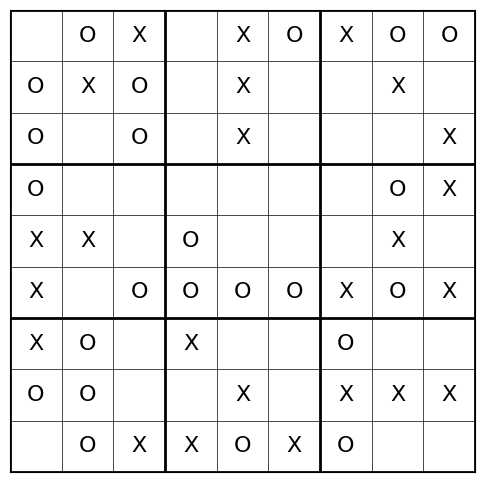

Winner: Player X

Final Result:


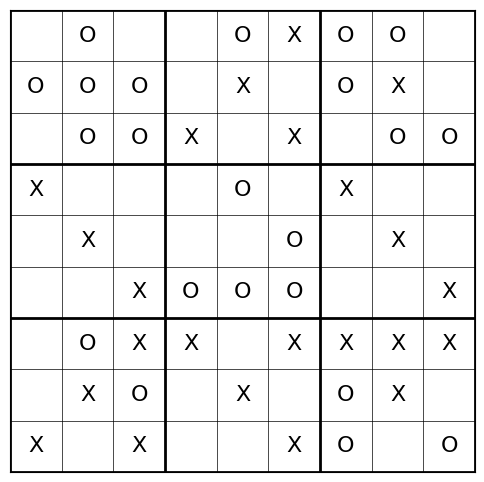

Winner: Player X
Iterations: 200 | Winrate vs Random: 0.00000

Summary Table: MCTS vs Abserd
   Iterations  Winrate_vs_Abserd
0         200                0.0


In [57]:
import numpy as np
import random

iteration_counts = [200]

# To store results
results_vs_random = []

def mcts_agent_factory(iterations):
    """
    Returns a function that runs MCTS with given iterations.
    """
    def agent(game):
        return enhanced_mcts(game, iterations=iterations)
    return agent

print("Testing MCTS vs Abserd...\n")
for iters in iteration_counts:
    wins = 0
    for _ in range(2):
        mcts_agent = mcts_agent_factory(iters)
        winner = play_game(mcts_agent, agent_ser_abserd)
        if winner == 1:
            wins += 1
    winrate = wins / 2
    results_vs_random.append((iters, winrate))
    print(f"Iterations: {iters} | Winrate vs Random: {winrate:.5f}")


import pandas as pd

df_random = pd.DataFrame(results_vs_random, columns=["Iterations", "Winrate_vs_Abserd"])

print("\nSummary Table: MCTS vs Abserd")
print(df_random)

##Report:


---



##**Round 2: Monte-Carlo vs Near Seer**
Near Seer can see the future, so long as it's within a 3x3 block.

It'll take the victories whereever it can find them.

In [58]:
def agent_near_seer(board):
    moves = board.get_legal_moves()
    for move in moves:
        big_r, big_c, small_r, small_c = move
        small_board = board.boards[big_r][big_c]
        temp_grid = small_board.grid.copy()
        temp_grid[small_r, small_c] = board.current_player

        # Check for immediate win in small board
        for i in range(3):
            if all(temp_grid[i, :] == board.current_player) or all(temp_grid[:, i] == board.current_player):
                return move
        if all(np.diag(temp_grid) == board.current_player) or all(np.diag(np.fliplr(temp_grid)) == board.current_player):
            return move
    return random.choice(moves)

##Prediction:
- Give a Range, how many moves do you think it'll take to win?
- At what Iteration Count do you think it'll take your bot to reach above 50% win rate.

Testing MCTS vs Random Agent...


Final Result:


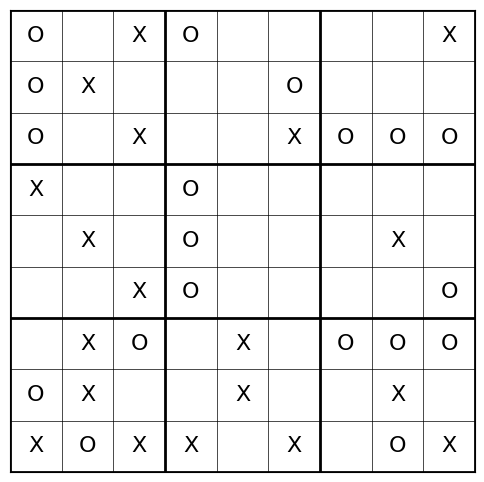

Winner: Player O


In [ ]:
import numpy as np
import random

iteration_counts = [200]

# To store results
results_vs_random = []

def mcts_agent_factory(iterations):
    """
    Returns a function that runs MCTS with given iterations.
    """
    def agent(game):
        return enhanced_mcts(game, iterations=iterations)
    return agent

print("Testing MCTS vs Random Agent...\n")
for iters in iteration_counts:
    wins = 0
    for _ in range(2):
        mcts_agent = mcts_agent_factory(iters)
        winner = play_game(mcts_agent, agent_near_seer)
        if winner == 1:
            wins += 1
    winrate = wins / 2
    results_vs_random.append((iters, winrate))
    print(f"Iterations: {iters} | Winrate vs Random: {winrate:.5f}")


import pandas as pd

df_random = pd.DataFrame(results_vs_random, columns=["Iterations", "Winrate_vs_Seer"])

print("\nSummary Table: MCTS vs Seer")
print(df_random)

##**Round 3: Monte-Carlo vs Count Erfit**

Count Erfit tries to mirror his last move, and if he can't, he'll mirror your last move.

In [ ]:
def count_erfit(board, last_self_move, last_opponent_move):
    """
    - First, tries to play same (small_r, small_c) as last own move
    - If not available, tries to play the exact opponent last move
    - If not, plays random
    """
    moves = board.get_legal_moves()

    if last_self_move:
        _, _, last_small_r, last_small_c = last_self_move
        for move in moves:
            if move[2] == last_small_r and move[3] == last_small_c:
                return move

    if last_opponent_move:
        target_move = last_opponent_move
        if target_move in moves:
            return target_move

    # Otherwise random
    return random.choice(moves)

def agent_count_erfit():
    """
    Returns an agent function compatible with play_game,
    internally tracks last_self_move and last_opponent_move.
    """
    last_self_move = [None]
    last_opponent_move = [None]

    def agent(game):
        move = count_erfit(game, last_self_move[0], last_opponent_move[0])
        last_opponent_move[0] = move  # for opponent tracking
        last_self_move[0] = move      # for self tracking
        return move

    return agent

##Prediction:
- Give a Range, how many moves do you think it'll take to win?
- At what Iteration Count do you think it'll take your bot to reach above 50% win rate.

#**Final Test: Monte-Carlo Vs Monte-Carlo(Opponent)**

At the end of the Gaunlet, the greatest battle is against one-self.

For this test, have the your Improved Monte Carlo Implementation compete vs the basic version from Part 2.


##Prediction:
- Give a Range, how many moves do you think it'll take to win?
- At what Iteration Count do you think it'll take your bot to reach above 50% win rate.

#Final Discussion!

Think about the 4 tests we have done with the Improved Monte-Carlo Implementation.

Can the Monte-Carlo bot be improved any further? If so, how? If not, why not?

##Answer:

